# Unisolar Projet
---

This project is based on the **UNISOLAR** open dataset containing information on solar energy production and weather in various locations of the La Trobe University, Victoria, Australia, stored in a time series format.

The main goal of this project will be to forecast energy production based on previous production and weather data with a horizon of 24 hours.

## Imports

---


In [3]:
import numpy as np
import pandas as pd
# import geopandas as gpd
pd.options.display.max_rows = 50
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
plt.style.use('fast')

## Loading and arranging data

---


The project contains three datasets:
- Power generation for 42 sites split in 5 campus locations as a function of time.
- Details of the different sites (number and type of solar panel, location, etc.)
- Weather data for the different campus.

In [5]:
power_path = 'data/Solar_Energy_Generation.csv'
sites_path = 'data/Solar_Site_Details.csv'
weather_path = 'data/Weather_Data_reordered_all.csv'

In [6]:
df_power = pd.read_csv(power_path, parse_dates=['Timestamp'])

In [7]:
df_power['CampusKey'] = df_power['CampusKey'].astype('int8')
df_power['SiteKey'] = df_power['SiteKey'].astype('int8')
df_power['SolarGeneration'] = df_power['SolarGeneration'].astype('float32')

In [8]:
df_power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731946 entries, 0 to 2731945
Data columns (total 4 columns):
 #   Column           Dtype         
---  ------           -----         
 0   CampusKey        int8          
 1   SiteKey          int8          
 2   Timestamp        datetime64[ns]
 3   SolarGeneration  float32       
dtypes: datetime64[ns](1), float32(1), int8(2)
memory usage: 36.5 MB


In [9]:
df_sites = pd.read_csv(sites_path) 

In [10]:
df_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CampusKey         42 non-null     int64  
 1   SiteKey           42 non-null     int64  
 2   kWp               25 non-null     float64
 3   Number of panels  25 non-null     float64
 4   Panel             25 non-null     object 
 5   Inverter          25 non-null     object 
 6   Optimizers        23 non-null     object 
 7   Metric            25 non-null     object 
 8   lat               42 non-null     float64
 9   Lon               42 non-null     float64
dtypes: float64(4), int64(2), object(4)
memory usage: 3.4+ KB


# Exploratory Data Analysis: Solar Energy Generation

---

In [14]:
df_power.head()

,CampusKey,SiteKey,Timestamp,SolarGeneration
0,2,1,2020-01-01 00:15:00,NaN
1,2,1,2020-01-01 00:30:00,NaN
2,2,1,2020-01-01 00:45:00,NaN
3,2,1,2020-01-01 01:00:00,NaN
4,2,1,2020-01-01 01:15:00,NaN


### Missing and duplicated data

In [15]:
print('Percent of missing date:\n', np.round(df_power.isna().sum()/len(df_power)*100), sep='')

Percent of missing date:
CampusKey           0.0
SiteKey             0.0
Timestamp           0.0
SolarGeneration    56.0
dtype: float64


More than 55% of the `SolarGeneration` data are missing.

In [16]:
print('Number of duplicated entries:', df_power.duplicated().sum())

Number of duplicated entries: 0


### Sites and campus

`SolarGeneration` data are recorded for 42 different sites, each located on different campus. 
We create a series `sites_in_campus` containing the site numbers belonging to each different campus.

In [17]:
sites_in_campus = df_power.groupby('CampusKey')['SiteKey'].unique()
print(sites_in_campus)

CampusKey
1    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
2                                      [1, 2, 3, 4, 5]
3                         [6, 7, 8, 9, 10, 11, 12, 13]
4                                                 [41]
5                                                 [42]
Name: SiteKey, dtype: object


### Solar Generation distribution accross sites

Let's see how `SolarGeneration` compares between the different sites.

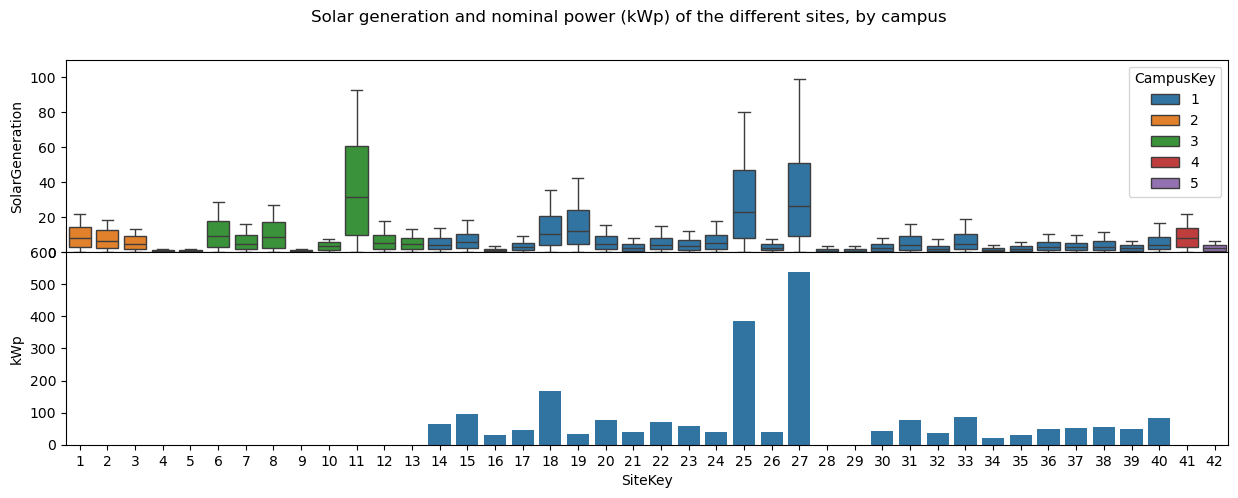

In [18]:
fig, axs = plt.subplots(2, 1, figsize = (15,5), sharex=True)
sns.boxplot(df_power, x='SiteKey', y='SolarGeneration', hue='CampusKey', palette='tab10', ax=axs[0])
sns.barplot(df_sites, x='SiteKey', y='kWp', hue='CampusKey', palette='tab10', ax=axs[1], legend=False)
fig.suptitle('Solar generation and nominal power (kWp) of the different sites, by campus')
fig.subplots_adjust(hspace=0)
axs[0].set_ylim(0, 110)
axs[1].set_ylim(0, 600);

The power generation varies significantly between sites. From the nominal power generation `kWp` (sum of nominal power of every panel in the site) for site 1 from the `df_sites` dataset, we see that different sites also have significantly different nominal power. This may account for most of the difference in power generation (but not all, as we can see when looking at sites number 18 and 19 for instance).


### Solar Generation series

From now on, it will be more convenient to work with the pivoted dataframe

In [19]:
df_power = df_power.pivot(index='Timestamp', columns='SiteKey', values='SolarGeneration')

In [164]:
df_power.head()

SiteKey,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
2020-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We make sure `Timestamp`is sorted and fill in missing values

In [166]:
df_power.head().index.is_monotonic_increasing

True

In [ ]:
time_series_idx = pd.pandas.date_range(min(df_weather.index), max(df_weather.index),freq='15min')
df_weather = df_weather.reindex(time_series_idx, fill_value=np.nan)

We can also look at the individual `SolarGeneration` time series for each campus.

In [21]:
def plot_solar_generation_sites(df, sites, figure_height=10, title=None):
    """
    Plots the evolution of `SolarGeneration`from the Dataframe `df` as a function of 'Timestamp' for selected sites.

    Parameters:
    - df (DataFrame): The DataFrame containing the solar generation data.
    - sites (list): A list of site number for which the solar generation will be plotted.
    - figure_height (int, optional): Height of the figure.
    - title (str, optional): Title for the entire plot.

    Returns:
    None

    This function creates subplots for each specified site, displaying the solar generation over time.
    The x-axis of all subplots is shared, providing a synchronized view.
    Each subplot is colored differently using the 'viridis' colormap, and legends are added for each site.
    Y-axis tick labels and ticks are removed, and a common x-axis label is added at the bottom of the plot.

    Example:
    plot_solar_generation_sites(solar_data, ['1', '2'], figure_height=8, title='Solar Generation Over Time')
    """
    cmap = mpl.colormaps['viridis'].resampled(len(sites))
    fig, axs = plt.subplots(len(sites), figsize=(15, figure_height), sharex=True, squeeze=False, gridspec_kw={'hspace': 0})
    for i, site in enumerate(sites):
        axs[i,0].plot(df.index, df[site], c=cmap(i), label=f'Site {site}')
        axs[i,0].legend(frameon=True, loc='center left')
        # axs[i,0].set_ylim(0)        
        axs[i,0].set(yticklabels=[])        # remove the ticks labels
        axs[i,0].tick_params(left=False)    # remove the ticks
    axs[-1,0].set_xlabel('Date')
    fig.suptitle(title, va='bottom')
    fig.text(0.1,0.5, "Solar Generation", ha="center", va="center", rotation=90)


For campus 1

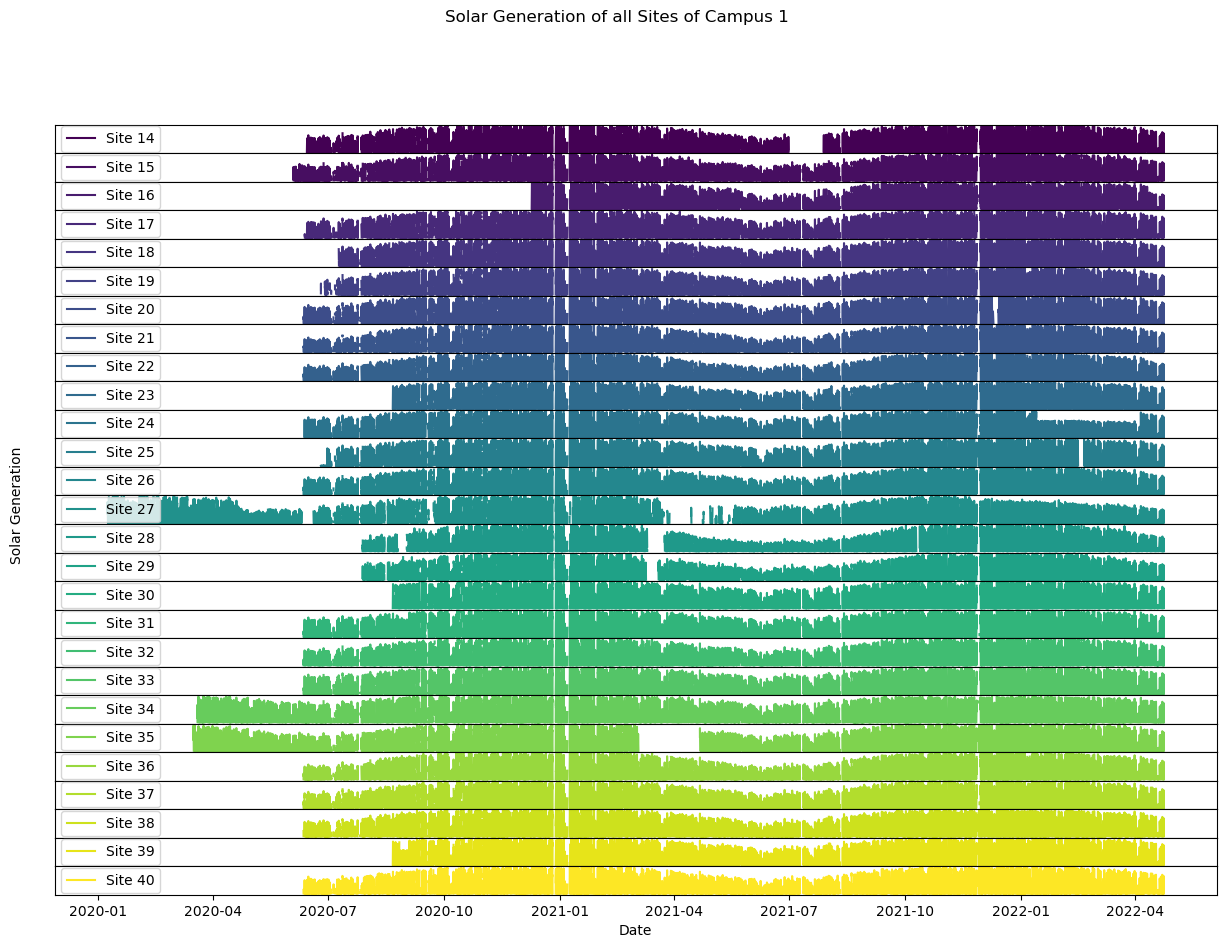

In [22]:
campus_number = 1
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 10, 'Solar Generation of all Sites of Campus 1')

For campus 2

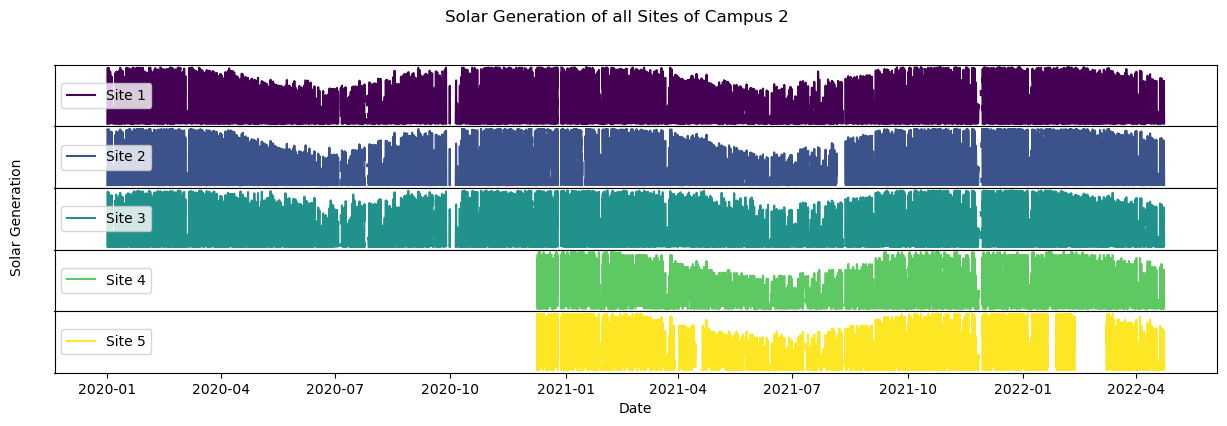

In [23]:
campus_number = 2
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 4, 'Solar Generation of all Sites of Campus 2')

For campus 3

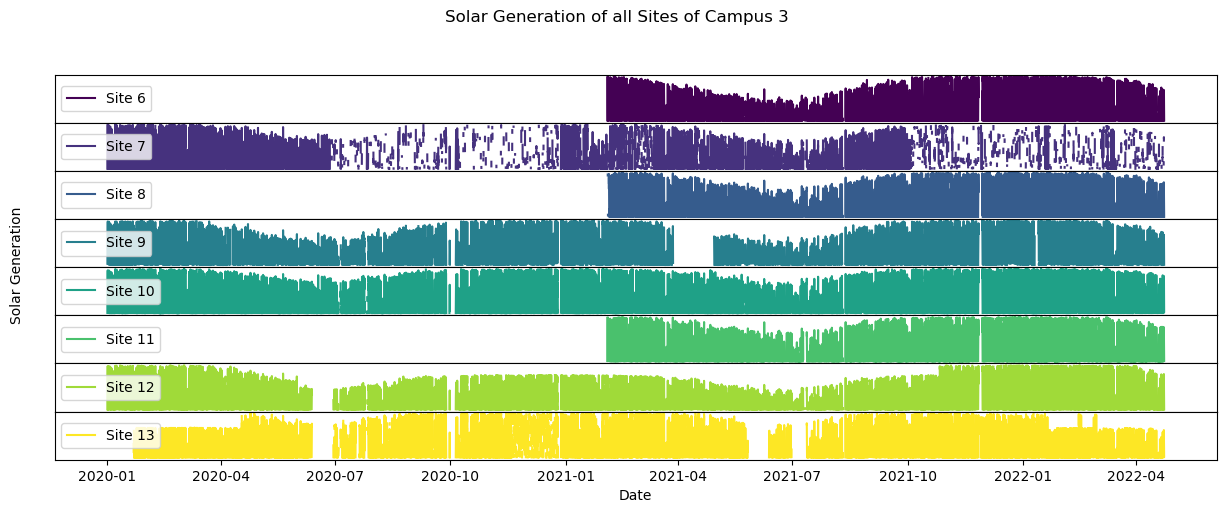

In [24]:
campus_number = 3
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 5, 'Solar Generation of all Sites of Campus 3')

For campus 4

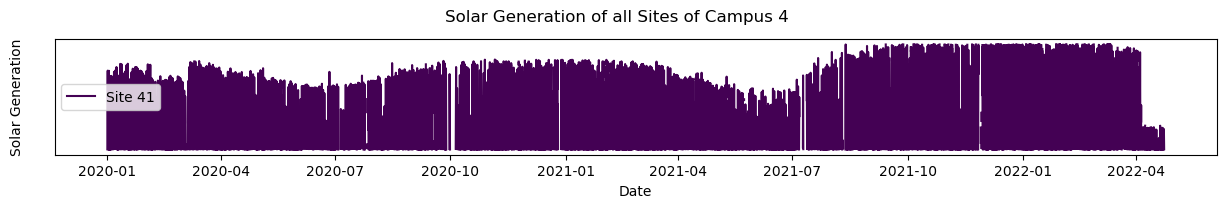

In [25]:
campus_number = 4
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 1.5, 'Solar Generation of all Sites of Campus 4')

And campus 5

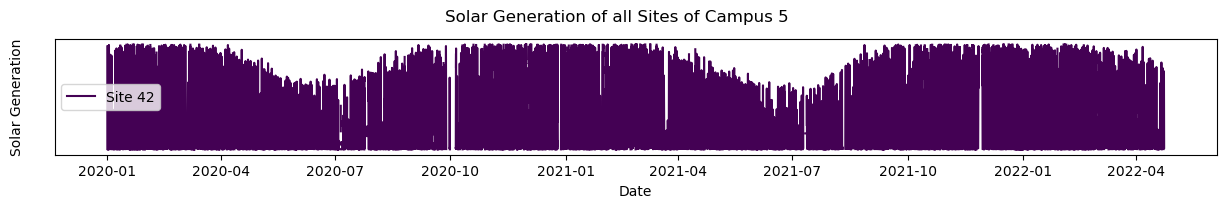

In [26]:
campus_number = 5
plot_solar_generation_sites(df_power, sites_in_campus[campus_number], 1.5, 'Solar Generation of all Sites of Campus 5')

We can make three observation after looking at these five plots:
- Origin of missing data. It seems that some sites were deployed later than others, resulting in missing data for extended periods of time. We also observe smaller intervals without data that are sometimes shared between different sites and may be due to technical issues.
- There seems to be a substansial correlation between `SolarGeneration` of the different sites belonging to the same campus. Asides from missing data, sites plots for a given campus look close to identical in relative units.
- The `SolarGeneration` from the different campus are similar in terms of seasonality, be we observed difference, for instance in the location of the minimum power generation.

### Solar Generation correlation

We can check the correlation `SolarGeneration` between sites of a given campus.
Campus 2 and 3 have a site numbers small enough so we can plot correlation heatmaps.

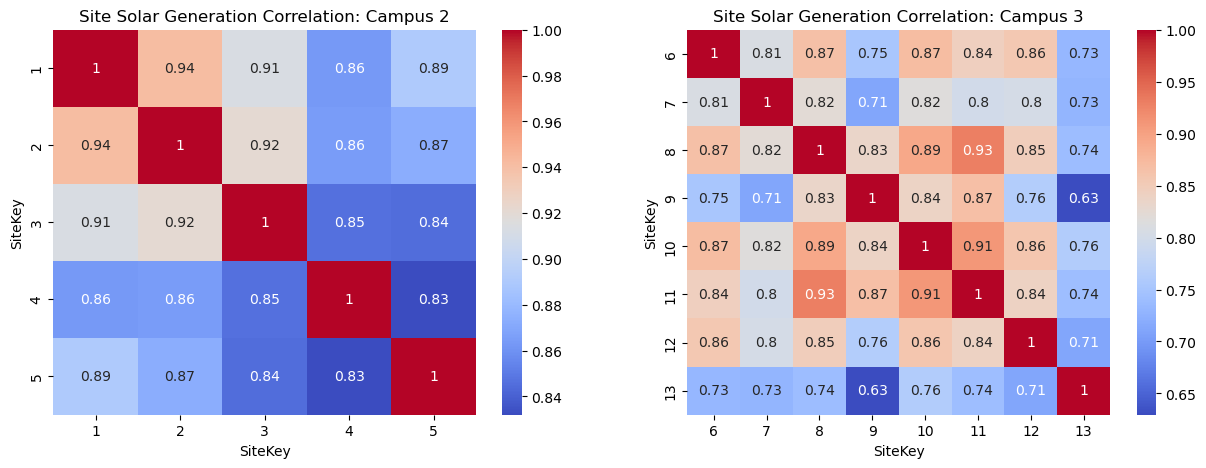

In [27]:
fig,axs = plt.subplots(1, 2, figsize=(15, 5))
for i, campus in enumerate([2, 3]):
    sns.heatmap(
        df_power[sites_in_campus[campus]].corr(method='kendall'),
        annot=True, cmap='coolwarm', ax=axs[i]
    )
    axs[i].set_title(f'Site Solar Generation Correlation: Campus {campus}');

The number of sites in campus 1 is to large to plot a heatmap, but we can find the lowest coefficient of correlation for all sites in campus 1:

Pivoting the Dataframe will be more convenient going forward.

In [28]:
print('Lowest site Solar Generation correlation coefficient for campus 1:',
       np.round(df_power[sites_in_campus[1]].corr().mean(axis=None)
                ,2
        )
)

Lowest site Solar Generation correlation coefficient for campus 1: 0.97


Campus 4 and 5 only have one site each.

Overal, the correlation coefficients for `SolarGeneration` between sites for each group is typically above 0.8. We will assume that each site is representative of its whole campus. To simplify our forecasting task, we will pick one site per campus. To decide which site to pick as a representative site, we will take a closer look at the missing data.

### Missing values

For each campus, we will use the site which the fewest missing values.

In [29]:
df_power[sites_in_campus[1]].isna().sum().sort_values().head(5)

SiteKey
27    44857
34    49632
15    50459
35    50774
24    50817
dtype: int64

Site 27 has fewer missing entries because its record starts earlier, but it has several large gap with no data. We will pick site 34 instead.

In [30]:
df_power[sites_in_campus[2]].isna().sum().sort_values().head()

SiteKey
1    42434
2    43242
3    43369
4    60530
5    62038
dtype: int64

In [31]:
df_power[sites_in_campus[3]].isna().sum().sort_values().head()

SiteKey
10    43559
12    43919
13    48377
9     49013
11    59678
dtype: int64

Sites number 27, 1, 10, 41, 42 are selected as representative of campus 1, 2, 3, 4 and 5, respectively.

In [32]:
selected_sites = [34, 1, 10, 41, 42]

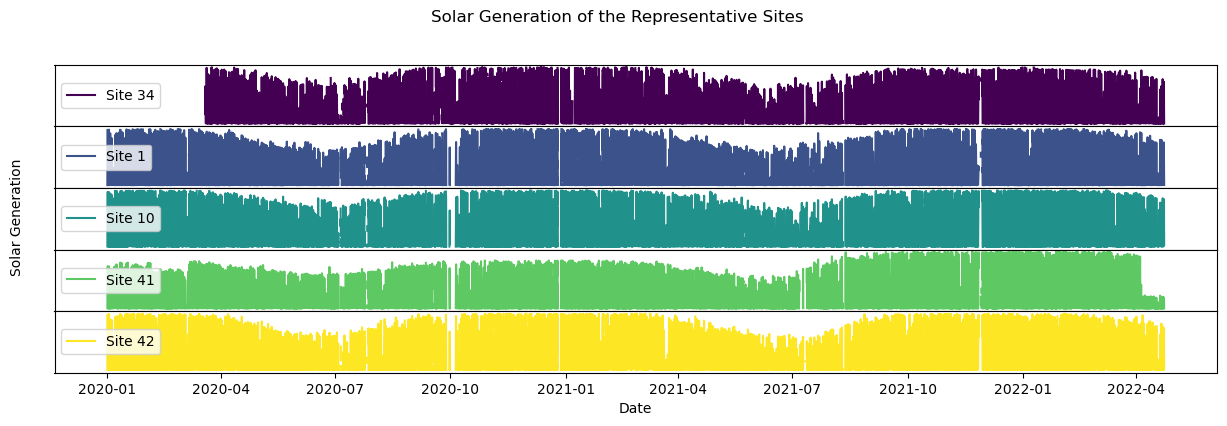

In [33]:
plot_solar_generation_sites(df_power, selected_sites, 4, 'Solar Generation of the Representative Sites')

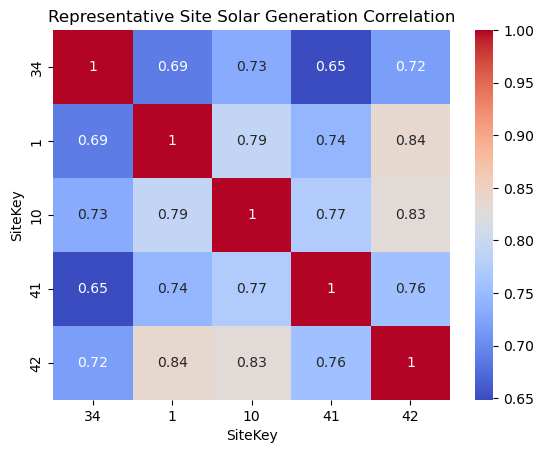

In [34]:
fig,axs = plt.subplots(1, 1)
sns.heatmap(df_power[selected_sites].corr(),
            annot=True, cmap='coolwarm', ax=axs)
axs.set_title(f'Representative Site Solar Generation Correlation');

As could be inferred by looking at the different times series, the correlation between sites of different campus if lower than correlation between sites of the same campus, as different locations may be subject to different weather conditions.

Looking at a smaller time window, we observe that the majority of missing data are between solar generation period, e.i. at night. There are also missing data during the day, but they are far less common and sometimes shared betweend sites .

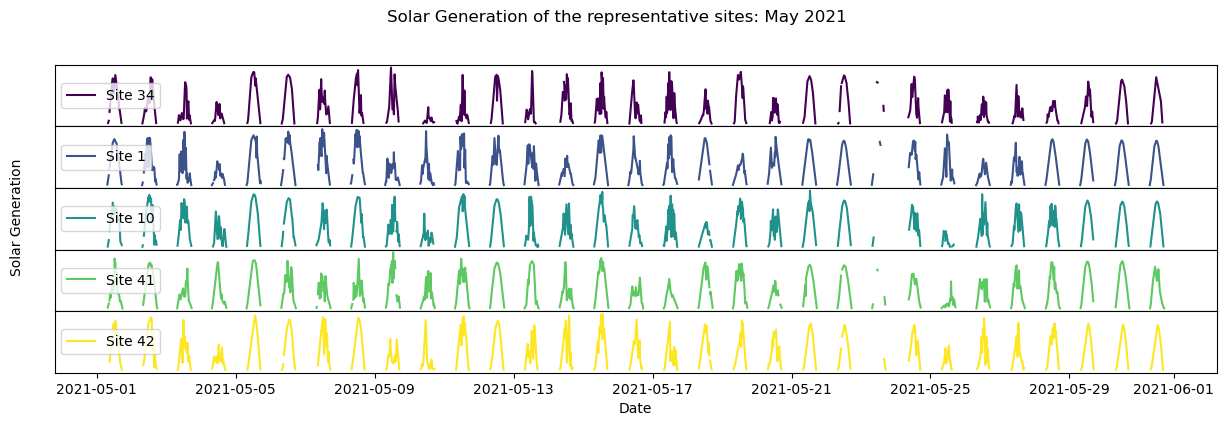

In [35]:
plot_solar_generation_sites(df_power.loc[pd.Timestamp('2021-05'):pd.Timestamp('2021-06')], selected_sites, 4, 'Solar Generation of the representative sites: May 2021')

Assuming the systems return `Nan` when `SolarGeneration` is smaller than a threshold power, it is possible that some daytime missing values are due to weather events leading the power generation to drop close to zer. Therefore it is safest to fill missing values with `0`.

In [36]:
df_power = df_power.fillna(0)

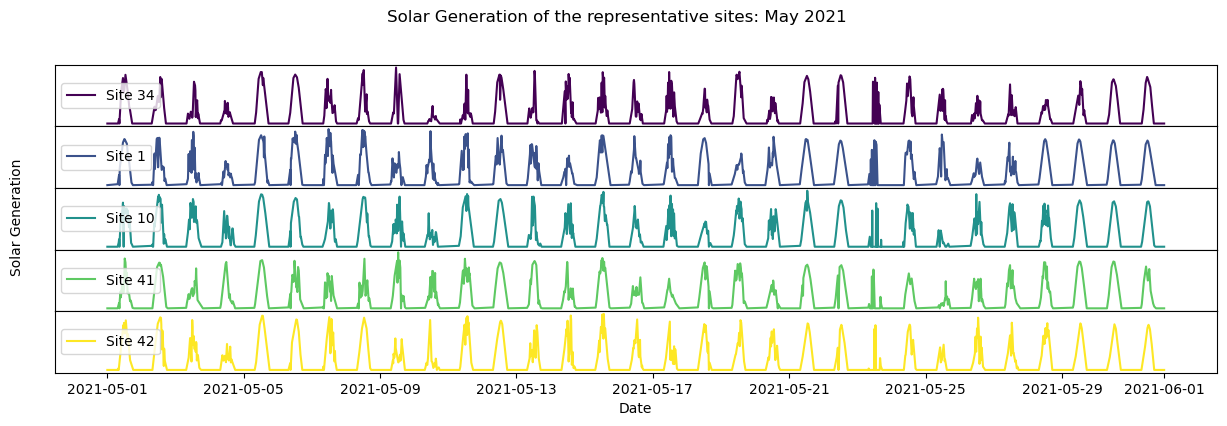

In [37]:
plot_solar_generation_sites(df_power.loc[pd.Timestamp('2021-05'):pd.Timestamp('2021-06')], selected_sites, 4, 'Solar Generation of the representative sites: May 2021')

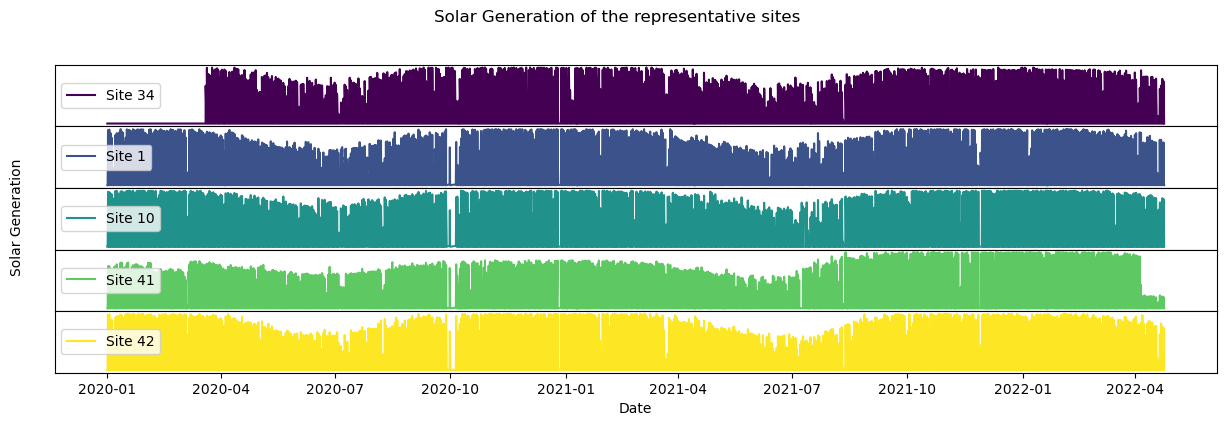

In [39]:
plot_solar_generation_sites(df_power, selected_sites, 4, 'Solar Generation of the representative sites')

Now the dataframe is empty of missing values.

# Exploratory Data Analysis: Site Details

---

# Exploratory Data Analysis: Weather

---

In [173]:
df_weather = pd.read_csv(weather_path, parse_dates=['Timestamp'])
df_weather['CampusKey'] = df_weather['CampusKey'].astype('int8')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371769 entries, 0 to 371768
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CampusKey            371769 non-null  int8          
 1   Timestamp            371769 non-null  datetime64[ns]
 2   ApparentTemperature  264656 non-null  float64       
 3   AirTemperature       264656 non-null  float64       
 4   DewPointTemperature  264656 non-null  float64       
 5   RelativeHumidity     264656 non-null  float64       
 6   WindSpeed            208879 non-null  float64       
 7   WindDirection        208879 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int8(1)
memory usage: 20.2 MB


In [174]:
df_weather.head()

,CampusKey,Timestamp,ApparentTemperature,AirTemperature,DewPointTemperature,RelativeHumidity,WindSpeed,WindDirection
0,1,2020-01-01 00:00:00,13.666667,13.880000,8.960000,72.400000,0.000000,188.133333
1,1,2020-01-01 00:15:00,13.206667,13.666667,9.040000,73.466667,1.200000,203.866667
2,1,2020-01-01 00:30:00,12.840000,13.553333,9.053333,74.000000,2.520000,222.800000
3,1,2020-01-01 00:45:00,12.113333,13.506667,9.100000,74.466667,5.986667,231.133333
4,1,2020-01-01 01:00:00,11.946667,13.260000,9.266667,76.533333,5.946667,247.866667


`df_weather` contains weather information for each campus stored as time series. `DewPointTemperature` and `ApparentTemperature` are both calculated using on `AirTemperature` and `RelativeHumidity`. We will drop these two columns for now as they don't add new information.

In [175]:
df_weather = df_weather.drop(columns=['ApparentTemperature','DewPointTemperature'])

## Distribution

We can take a look at the distribution of the weather features for the different campus locations.

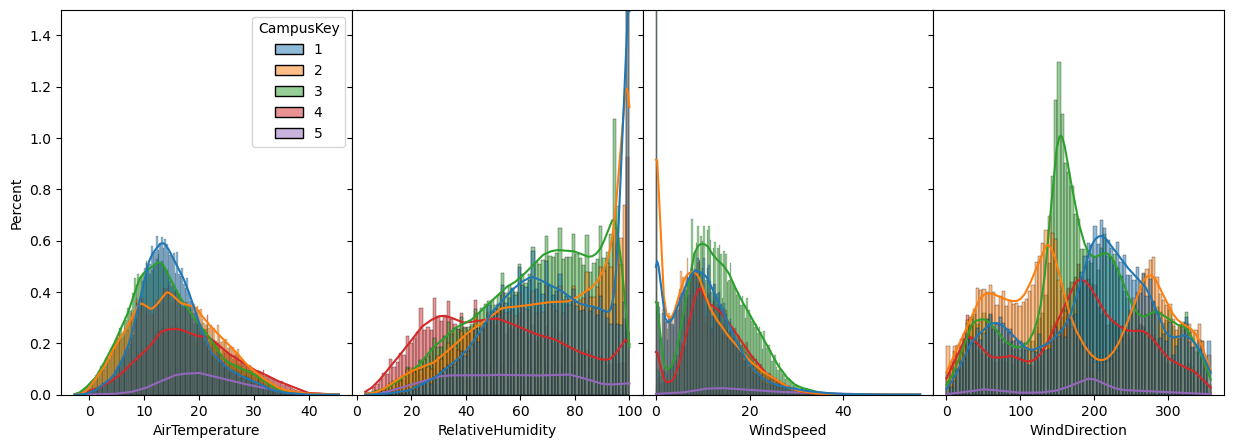

In [176]:
fig, axs = plt.subplots(1, 4, figsize=(15,5), sharey=True)
for i, columns in enumerate(['AirTemperature', 'RelativeHumidity', 'WindSpeed', 'WindDirection']):
    sns.histplot(df_weather, x=columns, hue='CampusKey', palette='tab10', ax=axs[i], legend=i==0, multiple='layer', stat='percent', kde=True)
axs[-1].set_ylim(0, 1.5)
fig.subplots_adjust(wspace=0)
# fig.tight_layout();

As can be seen from these histograms, the distributions of the different weather parameters vary significantly between the different campus locations.

## Time evolution

As for the solar generation data, pivoting the dataframe will make the analysis easier.

In [177]:
df_weather = df_weather.pivot(index='Timestamp', columns='CampusKey', values = ['AirTemperature','RelativeHumidity', 'WindSpeed', 'WindDirection']) 

In [178]:
df_weather.head()

AirTemperature                                       \
CampusKey                        1          2          3          4   5   
Timestamp                                                                 
2020-01-01 00:00:00      13.880000  20.140000  14.180000  21.620000 NaN   
2020-01-01 00:15:00      13.666667  20.300000  13.860000  21.246667 NaN   
2020-01-01 00:30:00      13.553333  19.840000  13.593333  20.940000 NaN   
2020-01-01 00:45:00      13.506667  19.886667  13.400000  20.633333 NaN   
2020-01-01 01:00:00      13.260000  19.540000  13.193333  20.400000 NaN   

                    RelativeHumidity                                       \
CampusKey                          1          2          3          4   5   
Timestamp                                                                   
2020-01-01 00:00:00        72.400000  49.200000  49.600000  24.800000 NaN   
2020-01-01 00:15:00        73.466667  50.266667  50.200000  26.266667 NaN   
2020-01-01 00:30:00        74.000000  50.666667  51.600000  27.533333 NaN   
2020-01-01 00:45:00        74.466667  51.000000  53.000000  28.800000 NaN   
2020-01-01 01:00:00        76.533333  51.133333  54.866667  29.933333 NaN   

                    WindSpeed                              WindDirection  \
CampusKey                   1          2      3      4   5             1   
Timestamp                                                                  
2020-01-01 00:00:00  0.000000  10.120000  14.32  17.28 NaN    188.133333   
2020-01-01 00:15:00  1.200000   8.680000  15.28  16.14 NaN    203.866667   
2020-01-01 00:30:00  2.520000   7.933333  13.60  16.86 NaN    222.800000   
2020-01-01 00:45:00  5.986667   8.440000  12.88  17.10 NaN    231.133333   
2020-01-01 01:00:00  5.946667   8.680000  13.60  18.72 NaN    247.866667   

                                                             
CampusKey                     2           3           4   5  
Timestamp                                                    
2020-01-01 00:00:00  180.666667  153.600000  206.733333 NaN  
2020-01-01 00:15:00  152.666667  158.666667  204.000000 NaN  
2020-01-01 00:30:00  157.533333  156.600000  200.866667 NaN  
2020-01-01 00:45:00  147.600000  148.533333  200.866667 NaN  
2020-01-01 01:00:00  151.333333  164.733333  197.066667 NaN

Before we go further, we will check if the timestamp index is sorted and make sure it does not contain missing values

In [179]:
df_weather.index.is_monotonic_increasing

True

In [180]:
time_series_idx = pd.pandas.date_range(min(df_weather.index), max(df_weather.index),freq='15min')
df_weather = df_weather.reindex(time_series_idx, fill_value=np.nan)

Now we can look individually at all weather features as a function of time for each campuses. We will also report the number of non-missing entries.

In [181]:
def plot_campus_weather_feature(df, column, campus, title=None):
    """
    Plots the specified weather feature from the DataFrame `df` for different campuses as a function of timestamp and print non-null data counts.

    Parameters:
    - df (DataFrame): The DataFrame containing the weather data.
    - column (str): The name of the weather feature to be plotted.
    - campus (list): A list of campus names for which the data will be plotted.
    - title (str, optional): Title for the entire plot.

    Returns:
    None

    This function creates subplots for each specified campus, displaying the weather feature over time.
    The x-axis of all subplots is shared, providing a synchronized view.
    Each subplot is colored differently using the 'viridis' colormap, and non-null data counts are printed.

    Example:
    plot_weather_feature_campus(weather_data, 'Temperature', ['CampusA', 'CampusB'], title='Temperature Variation')
    """
    cmap = mpl.colormaps['viridis'].resampled(len(campus))
    fig, axs = plt.subplots(len(campus), 1, figsize=(15, 7), sharex=True, squeeze=False) 
    for i, camp in enumerate(campus):
        axs[i, 0].scatter(df.index, df.loc[:, (column, camp)], color=cmap(i), s=1)
        axs[i, 0].scatter([], [], color=cmap(i), s=10, label=f'Campus {camp}')
        print(f'Campus {camp}: {df.loc[:, (column, camp)].notnull().values.sum()} non-null data')
        axs[i, 0].legend(loc='center left')
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0)

Campus 1: 66222 non-null data
Campus 2: 68254 non-null data
Campus 3: 72275 non-null data
Campus 4: 45595 non-null data
Campus 5: 12310 non-null data


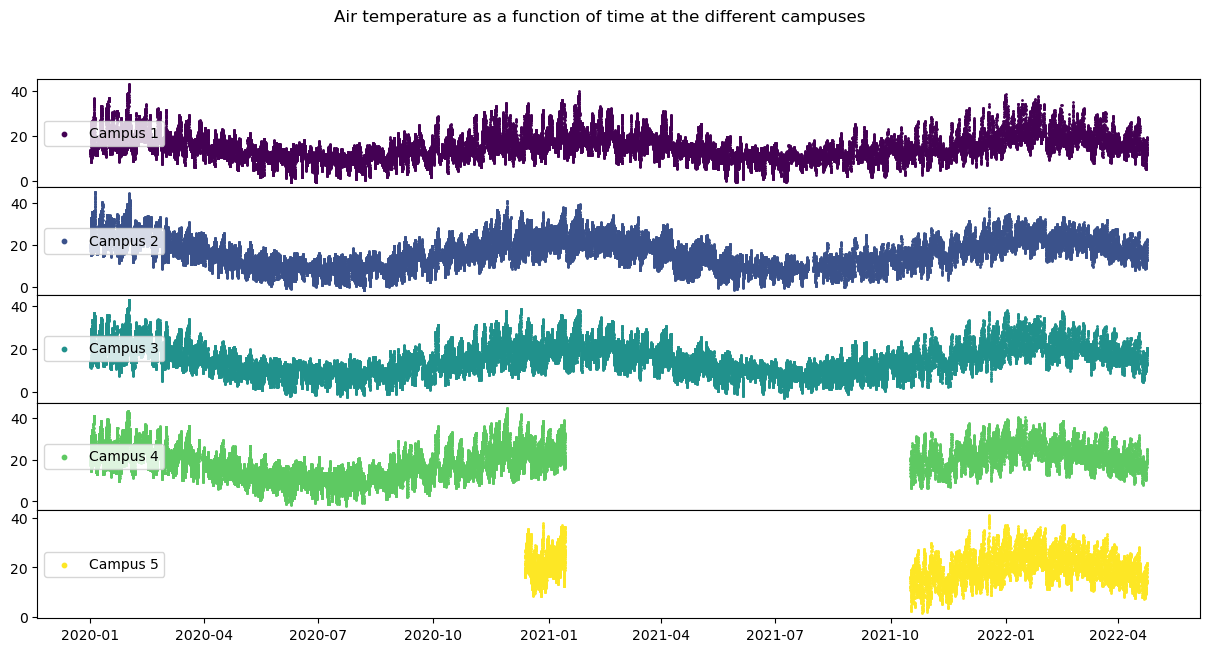

In [182]:
plot_campus_weather_feature(df_weather, ['AirTemperature'], sites_in_campus.index, 'Air temperature as a function of time at the different campuses')

We are missing a big part of the `AirTemperature` data for site campus 4, and almost of the data for campus 5. Overall, the curves look similar.

Campus 1: 66222 non-null data
Campus 2: 68254 non-null data
Campus 3: 72275 non-null data
Campus 4: 45595 non-null data
Campus 5: 12310 non-null data


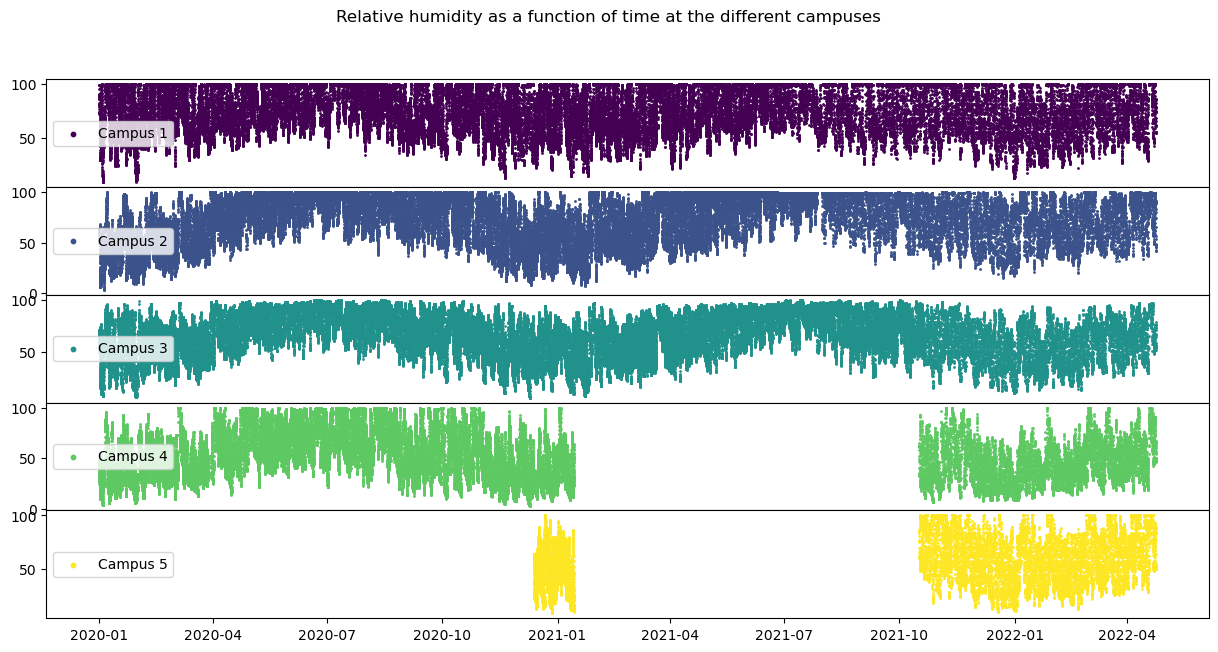

In [183]:
plot_campus_weather_feature(df_weather, ['RelativeHumidity'], sites_in_campus.index, 'Relative humidity as a function of time at the different campuses')

Large amount of missing data as well for `RelativeHumidity` at campus 5. We can clearly see the different types of weather with the fraction of data at 100% relative humidity.

Campus 1: 51327 non-null data
Campus 2: 54975 non-null data
Campus 3: 63139 non-null data
Campus 4: 36355 non-null data
Campus 5: 3083 non-null data


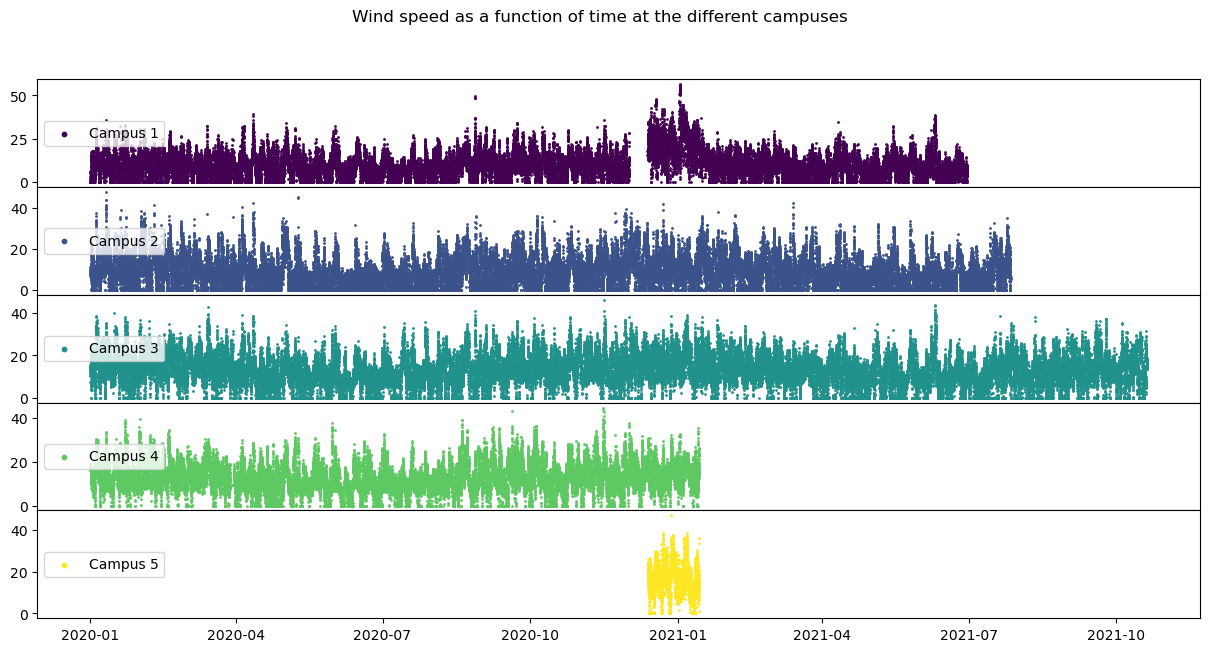

In [184]:
plot_campus_weather_feature(df_weather, ['WindSpeed'], sites_in_campus.index, 'Wind speed as a function of time at the different campuses')

Again, many missing entries for campus 5. Campus 3 seems to have the largest number of entries.

Campus 1: 51327 non-null data
Campus 2: 54975 non-null data
Campus 3: 63139 non-null data
Campus 4: 36355 non-null data
Campus 5: 3083 non-null data


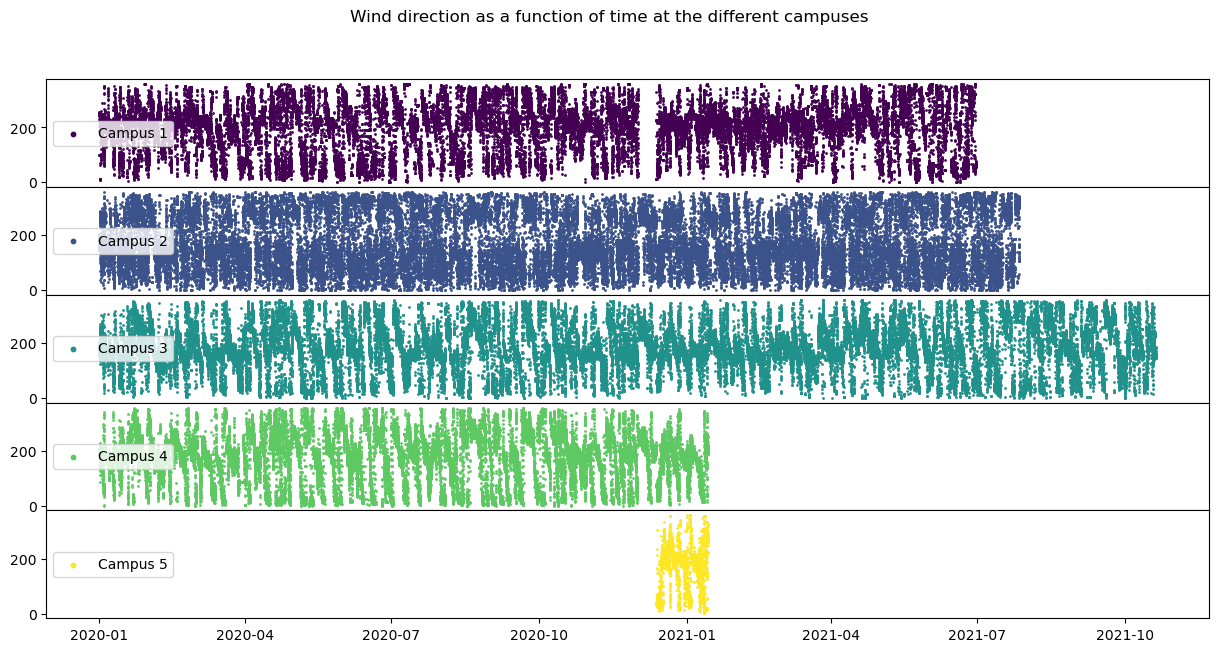

In [185]:
plot_campus_weather_feature(df_weather, ['WindDirection'], sites_in_campus.index, 'Wind direction as a function of time at the different campuses')

We see that `WindDirection` is encoded as an angle between 0 and 360. It will make more sense to use label enconding to represent `WindDirection`. Before we do so, let's take a look at the correlation heatmap between all the weather parameters at the different sites.

## Correlations

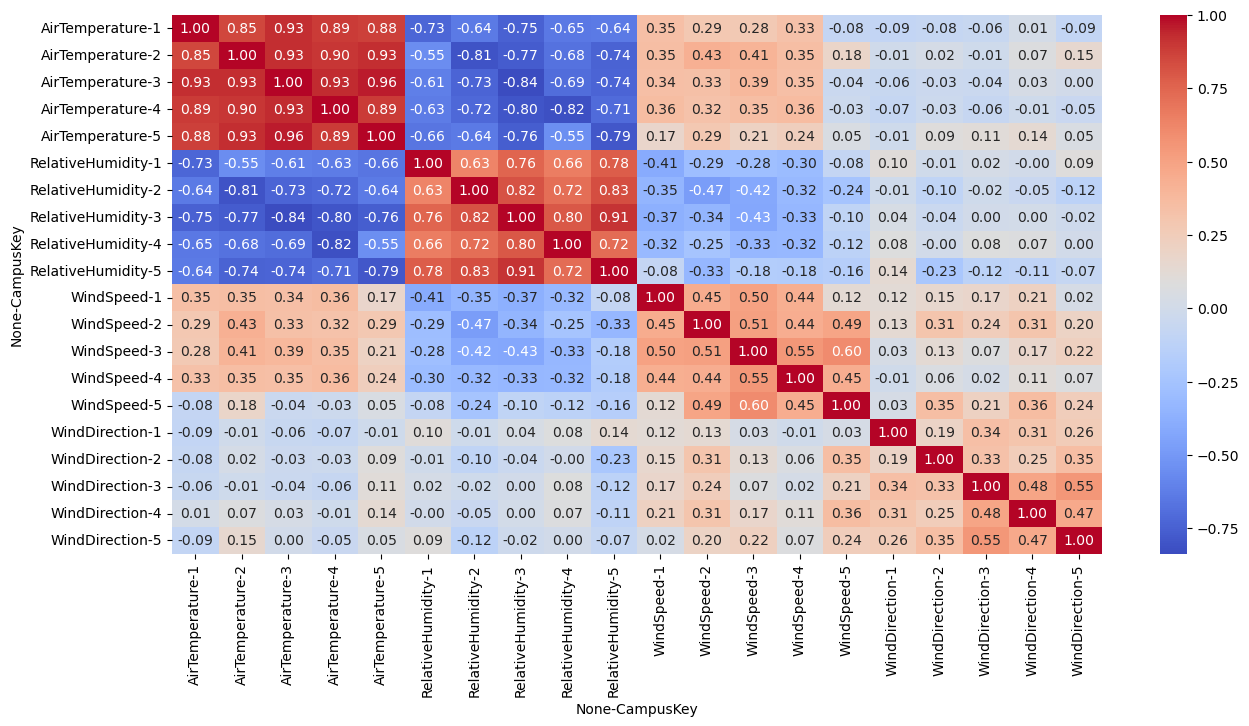

In [186]:
fig, ax = plt.subplots(1, figsize=(15,7))
sns.heatmap(df_weather.corr(), cmap='coolwarm', annot=True, fmt='.2f');

We observe a significant correlation between different campuses for a given weather feature. We also see that the correlation between `AirTemperature` and `Relative Humidity` is a substantial. They are also correlated to `WindSpeed` to a lesser extent. `Wind direction` is only weakly correlated to `WindSpeed`.

## Encoding

To label encode `WindDirection`, we just cut the series into 45º bins, resulting in N, NE, E, SE, S, SW, W, NW labels.

In [187]:
orientation_bins = [0, 22.5,  67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 382.5]
orientation_names = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
df_weather['WindDirection'] = df_weather['WindDirection'].apply(lambda x : pd.cut(x, bins=orientation_bins, labels=orientation_names, ordered=False, include_lowest=True))

In [188]:
df_weather.head()

AirTemperature                                       \
CampusKey                        1          2          3          4   5   
2020-01-01 00:00:00      13.880000  20.140000  14.180000  21.620000 NaN   
2020-01-01 00:15:00      13.666667  20.300000  13.860000  21.246667 NaN   
2020-01-01 00:30:00      13.553333  19.840000  13.593333  20.940000 NaN   
2020-01-01 00:45:00      13.506667  19.886667  13.400000  20.633333 NaN   
2020-01-01 01:00:00      13.260000  19.540000  13.193333  20.400000 NaN   

                    RelativeHumidity                                       \
CampusKey                          1          2          3          4   5   
2020-01-01 00:00:00        72.400000  49.200000  49.600000  24.800000 NaN   
2020-01-01 00:15:00        73.466667  50.266667  50.200000  26.266667 NaN   
2020-01-01 00:30:00        74.000000  50.666667  51.600000  27.533333 NaN   
2020-01-01 00:45:00        74.466667  51.000000  53.000000  28.800000 NaN   
2020-01-01 01:00:00        76.533333  51.133333  54.866667  29.933333 NaN   

                    WindSpeed                              WindDirection      \
CampusKey                   1          2      3      4   5             1   2   
2020-01-01 00:00:00  0.000000  10.120000  14.32  17.28 NaN             S   S   
2020-01-01 00:15:00  1.200000   8.680000  15.28  16.14 NaN            SW  SE   
2020-01-01 00:30:00  2.520000   7.933333  13.60  16.86 NaN            SW   S   
2020-01-01 00:45:00  5.986667   8.440000  12.88  17.10 NaN            SW  SE   
2020-01-01 01:00:00  5.946667   8.680000  13.60  18.72 NaN             W  SE   

                                  
CampusKey             3   4    5  
2020-01-01 00:00:00  SE  SW  NaN  
2020-01-01 00:15:00   S  SW  NaN  
2020-01-01 00:30:00  SE   S  NaN  
2020-01-01 00:45:00  SE   S  NaN  
2020-01-01 01:00:00   S   S  NaN

In [206]:
def plot_windorientation_allcampus(df):
    """
    Plots encoded wind direction the 5 campus as a function of timestamp, in different graphs.
    """
    fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)
    for i, camp in enumerate(sites_in_campus.index):
        sns.countplot(x=df.loc[:, ('WindDirection', camp)], ax=axs[i], label=f'Campus {camp}')
        axs[i].legend(loc='center left')  
    fig.subplots_adjust(hspace=0)

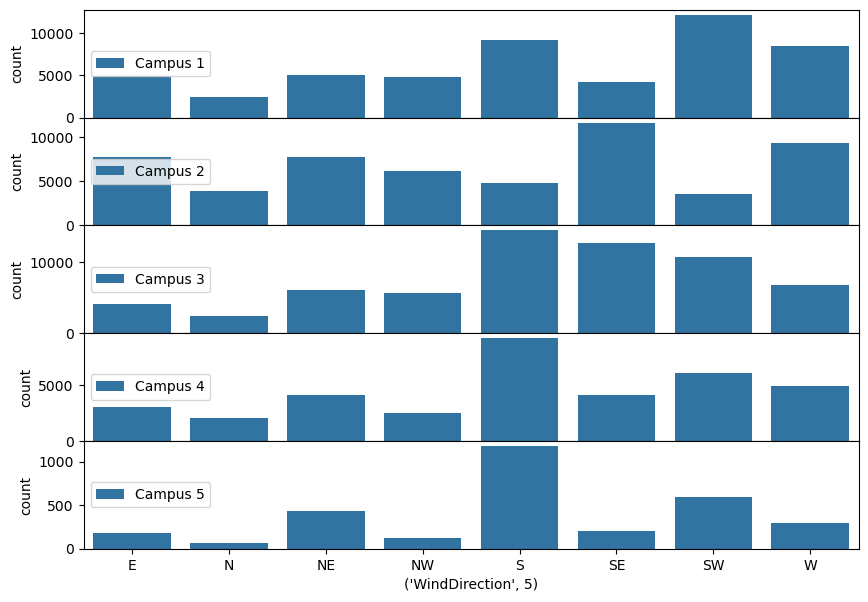

In [207]:
plot_windorientation_allcampus(df_weather)

# Merging dataset

In [213]:
df_preprocess = pd.merge(df_power[[10]],df_weather.xs(key=3,axis=1,level=1),how = 'left',on = 'Timestamp')

KeyError: 'Timestamp'

In [ ]:
sns.heatmap(df)